# [Jansen-Rit whole brain Numba imentation](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/jansen_rit_sde_numba.ipynb)


In [25]:
import os
import vbi
import torch
import pickle
import numpy as np
from tqdm import tqdm
import networkx as nx
import sbi.utils as utils
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sbi.analysis import pairplot
from vbi.inference import Inference
from vbi.models.numba.jansen_rit import JR_sde
from sklearn.preprocessing import StandardScaler

In [2]:
from vbi import report_cfg, update_cfg
from vbi import extract_features_df
from vbi import get_features_by_domain, get_features_by_given_names
from helpers import *

In [28]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);
path = "output/jr_numba/"
os.makedirs(path, exist_ok=True)

In [4]:
LABESSIZE = 12
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

number of nodes: 84


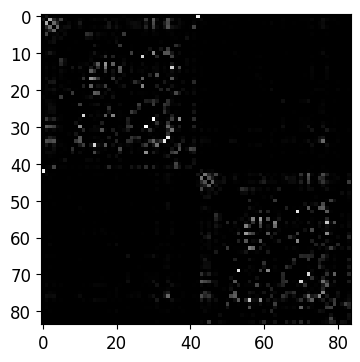

In [5]:
D = vbi.LoadSample(nn=84)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
ax.imshow(weights, cmap="gray", vmin=0, vmax=1);

In [6]:
par = {
    "G": 1.0,
    "mu": 0.24,
    "noise_amp": 0.1,
    "dt": 0.05,
    "C0": 135.0 * 1.0,
    "C1": 135.0 * 0.8,
    "C2": 135.0 * 0.25,
    "C3": 135.0 * 0.25,
    "weights": weights,
    "t_cut": 500.0,      # ms
    "t_end": 2501.0,     # ms
    "seed": seed,
    "decimate": 1
}

In [7]:
jr = JR_sde(par)
# print(jr)

In [8]:
# G, C1
theta_true = [1.5, 135]

In [9]:
# C1 needs to be a vector of size nn
C1 = theta_true[1]
theta_true_dict = {"G": 1.0, "C1":C1}
data = jr.run(theta_true_dict)

print(data['t'].shape, data['x'].shape)

(40020,) (40020, 84)


(10006,) (10006, 84)


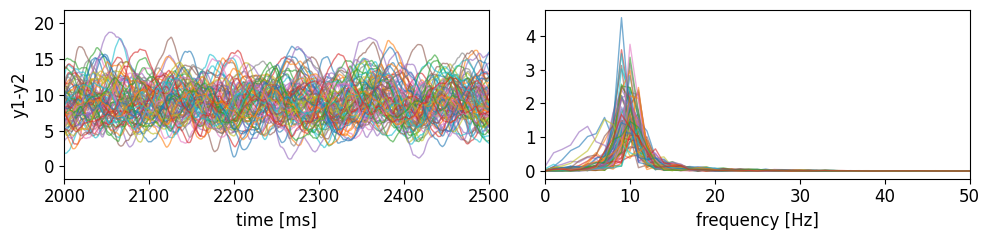

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))
plot_ts_pxx_jr(data, par, [ax[0], ax[1]], alpha=0.6, lw=1)
ax[0].set_xlim(2000, 2500)
plt.tight_layout()

In [11]:
cfg = get_features_by_domain(domain="spectral")
cfg = get_features_by_given_names(cfg, names=['spectrum_stats', 'spectrum_auc', "spectrum_moments"])
update_cfg(cfg, "spectrum_stats", {"fs": 1000/ par['dt'], "method": "welch", "average":True})
update_cfg(cfg, "spectrum_auc", {"fs": 1000/ par['dt'], "method": "welch", "average":True})
update_cfg(cfg, "spectrum_moments", {"fs": 1000/ par['dt'], "method": "welch", "average":True})
report_cfg(cfg)

Selected features:
------------------
■ Domain: spectral
 ▢ Function:  spectrum_stats
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_stats
   ▫ parameters :  {'fs': 20000.0, 'nperseg': None, 'indices': None, 'verbose': False, 'average': True, 'method': 'welch', 'features': ['spectral_distance', 'fundamental_frequency', 'max_frequency', 'max_psd', 'median_frequency', 'spectral_centroid', 'spectral_kurtosis', 'spectral_variation']}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  spectrum_moments
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_moments
   ▫ parameters :  {'fs': 20000.0, 'nperseg': None, 'method': 'welch', 'moments': [2, 3, 4, 5, 6], 'normalize': False, 'verbose': False, 'indices': None, 'average': True}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  spectrum_auc
   ▫ description:  Computes the area under the curve

In [12]:
from copy import deepcopy

def wrapper(par, control, cfg, verbose=False, with_labels=False):
    g, c1 = control
    par1 = deepcopy(par)
    control = {"G": g, "C1": c1}

    ode = JR_sde(par1)
    sol = ode.run(control)

    # extract features
    fs = 1.0 / par['dt'] * 1000  # [Hz]
    stat = extract_features_df(ts=[sol['x'].T],
                                      cfg=cfg,
                                      fs=fs,
                                      n_workers=1,
                                      verbose=verbose)
    value = stat.values
    if with_labels:
        label = list(stat.columns)
        return value[0], label
    return value[0]

In [13]:
def batch_run(par, control_list, cfg, n_workers=1):
    n = len(control_list)
    def update_bar(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=n) as pbar:
            async_results = [pool.apply_async(wrapper,
                                              args=(
                                                  par, control_list[i], cfg, False),
                                              callback=update_bar)
                             for i in range(n)]
            stat_vec = [res.get() for res in async_results]
    return stat_vec

In [14]:
x_, labels = wrapper(par, theta_true, cfg, with_labels=True)
len(x_), labels

(18,
 ['spectral_distance_0',
  'fundamental_frequency_0',
  'max_frequency_0',
  'max_psd_0',
  'median_frequency_0',
  'spectral_centroid_0',
  'spectral_kurtosis_0',
  'spectral_variation_0',
  'spectrum_moment_2',
  'spectrum_moment_3',
  'spectrum_moment_4',
  'spectrum_moment_5',
  'spectrum_moment_6',
  'spectrum_auc_0',
  'spectrum_auc_1',
  'spectrum_auc_2',
  'spectrum_auc_3',
  'spectrum_auc_4'])

In [15]:
num_sim = 2000
num_workers = 10
C1_min, C1_max = 130.0, 300.0
G_min, G_max = 0.0, 5.0
prior_min = [G_min, C1_min]
prior_max = [G_max, C1_max]
prior = utils.BoxUniform(low=torch.tensor(prior_min),
                         high=torch.tensor(prior_max))

In [16]:
obj = Inference()
theta = obj.sample_prior(prior, num_sim) # sample from prior with uniform distribution
theta_np = theta.numpy().astype(float)

- produce training data

In [17]:
stat_vec = batch_run(par, theta_np, cfg, num_workers)

100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s]


- Visualizing the feature distribution vs global coupling/C1

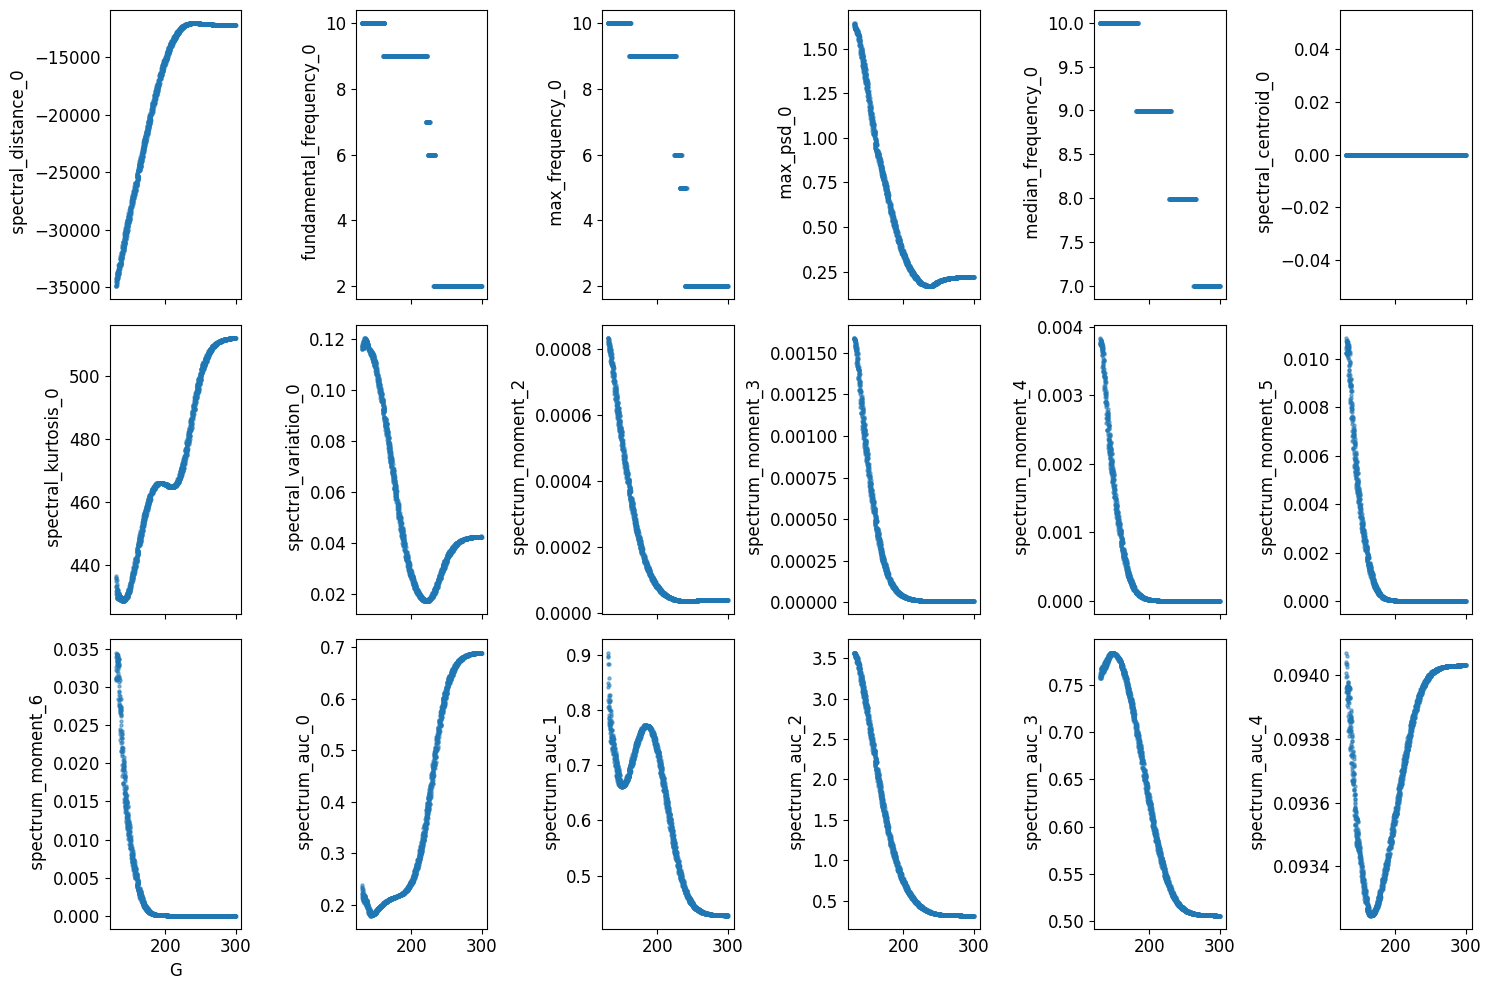

In [24]:
stat_vec_arr = np.array(stat_vec)
fig, axes = plt.subplots(3, 6, figsize=(15, 10), sharex=True)
for i in range(stat_vec_arr.shape[1]):
    axes[i // 6, i % 6].scatter(theta_np[:, 1], stat_vec_arr[:, i], s=5, alpha=0.5)
    axes[i // 6, i % 6].set_ylabel(f" {labels[i]}")
axes[-1, 0].set_xlabel("G")
plt.tight_layout()
# turn off axis for empty subplots
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')


- standardizing the features (optional)
- droping features with small variance

In [ ]:
import os
os.makedirs('output', exist_ok=True)

scaler = StandardScaler()
stat_vec_st = scaler.fit_transform(np.array(stat_vec))
# drop columns with zero variance, keep indices of remaining columns
non_zero_var_indices = np.var(stat_vec_st, axis=0) > 1e-6
stat_vec_st = stat_vec_st[:, non_zero_var_indices]
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)

torch.save(theta, path + 'theta.pt')
torch.save(stat_vec_st, path + 'stat_vec.pt')
print(theta.shape, stat_vec_st.shape)

torch.Size([2000, 2]) torch.Size([2000, 17])


In [20]:
posterior = obj.train(theta, stat_vec_st, prior, method="SNPE", density_estimator="maf")

 Neural network successfully converged after 173 epochs.train Done in 0 hours 0 minutes 23.953919 seconds


In [21]:
xo = wrapper(par, theta_true, cfg)
xo_st = scaler.transform(xo.reshape(1, -1))
xo_st = xo_st[:, non_zero_var_indices]

In [ ]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
torch.save(samples, path + 'samples.pt')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

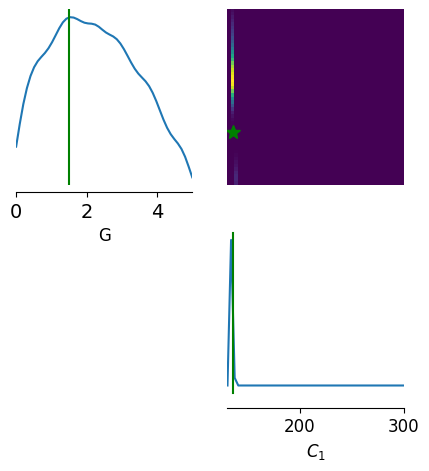

In [ ]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
points = [theta_true]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=points,
    labels=["G", r"$C_{1}$"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
fig.savefig(path + "jr_sde_cpp.jpeg", dpi=300)